# **MLP FOOD101**


In [ ]:
!pip install torchvision
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

**Importaciones necesarias**

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
# Verificar GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo de entrenamiento: {device}")


Dispositivo de entrenamiento: cuda


**Descarga y filtrado del dataset**

In [ ]:
# Clases seleccionadas (10 ejemplos de Food-101)
SELECTED_CLASSES = [
    'apple_pie', 'bruschetta', 'caesar_salad', 'cheesecake', 'chicken_curry',
    'chocolate_cake', 'french_fries', 'hamburger', 'pizza', 'sushi'
]

# Transformaciones para las imágenes
IMG_SIZE = 64
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])
])

# Descargar dataset completo
full_train = torchvision.datasets.Food101(
    root='./data',
    split='train',
    download=True,
    transform=transform  # Aplicamos transform aquí directamente
)

full_test = torchvision.datasets.Food101(
    root='./data',
    split='test',
    download=True,
    transform=transform
)

# Obtener índices de nuestras clases seleccionadas
all_classes = full_train.classes
class_indices = [all_classes.index(cls) for cls in SELECTED_CLASSES]
class_to_new_label = {cls_idx: new_label for new_label, cls_idx in enumerate(class_indices)}

# Función para filtrar los datasets
def filter_dataset(dataset, class_indices):
    # Obtenemos todos los índices y etiquetas
    indices_and_labels = [(idx, dataset._labels[idx]) for idx in range(len(dataset))]

    # Filtramos por nuestras clases
    filtered_indices = [idx for idx, label in indices_and_labels if label in class_indices]

    # Creamos el subset
    subset = torch.utils.data.Subset(dataset, filtered_indices)

    # Definimos transformación de etiquetas
    def transform_label(label):
        return class_to_new_label[label]

    # Aplicamos la transformación de etiquetas
    subset.dataset.target_transform = transform_label

    return subset

# Crear datasets filtrados
train_dataset = filter_dataset(full_train, class_indices)
test_dataset = filter_dataset(full_test, class_indices)

# Verificación
print(f"Clases seleccionadas: {SELECTED_CLASSES}")
print(f"Número de imágenes de entrenamiento: {len(train_dataset)}")
print(f"Número de imágenes de prueba: {len(test_dataset)}")

100%|██████████| 5.00G/5.00G [04:00<00:00, 20.7MB/s]


Clases seleccionadas: ['apple_pie', 'bruschetta', 'caesar_salad', 'cheesecake', 'chicken_curry', 'chocolate_cake', 'french_fries', 'hamburger', 'pizza', 'sushi']
Número de imágenes de entrenamiento: 7500
Número de imágenes de prueba: 2500


**Visualizacion de 20 imagenes del Dataset**

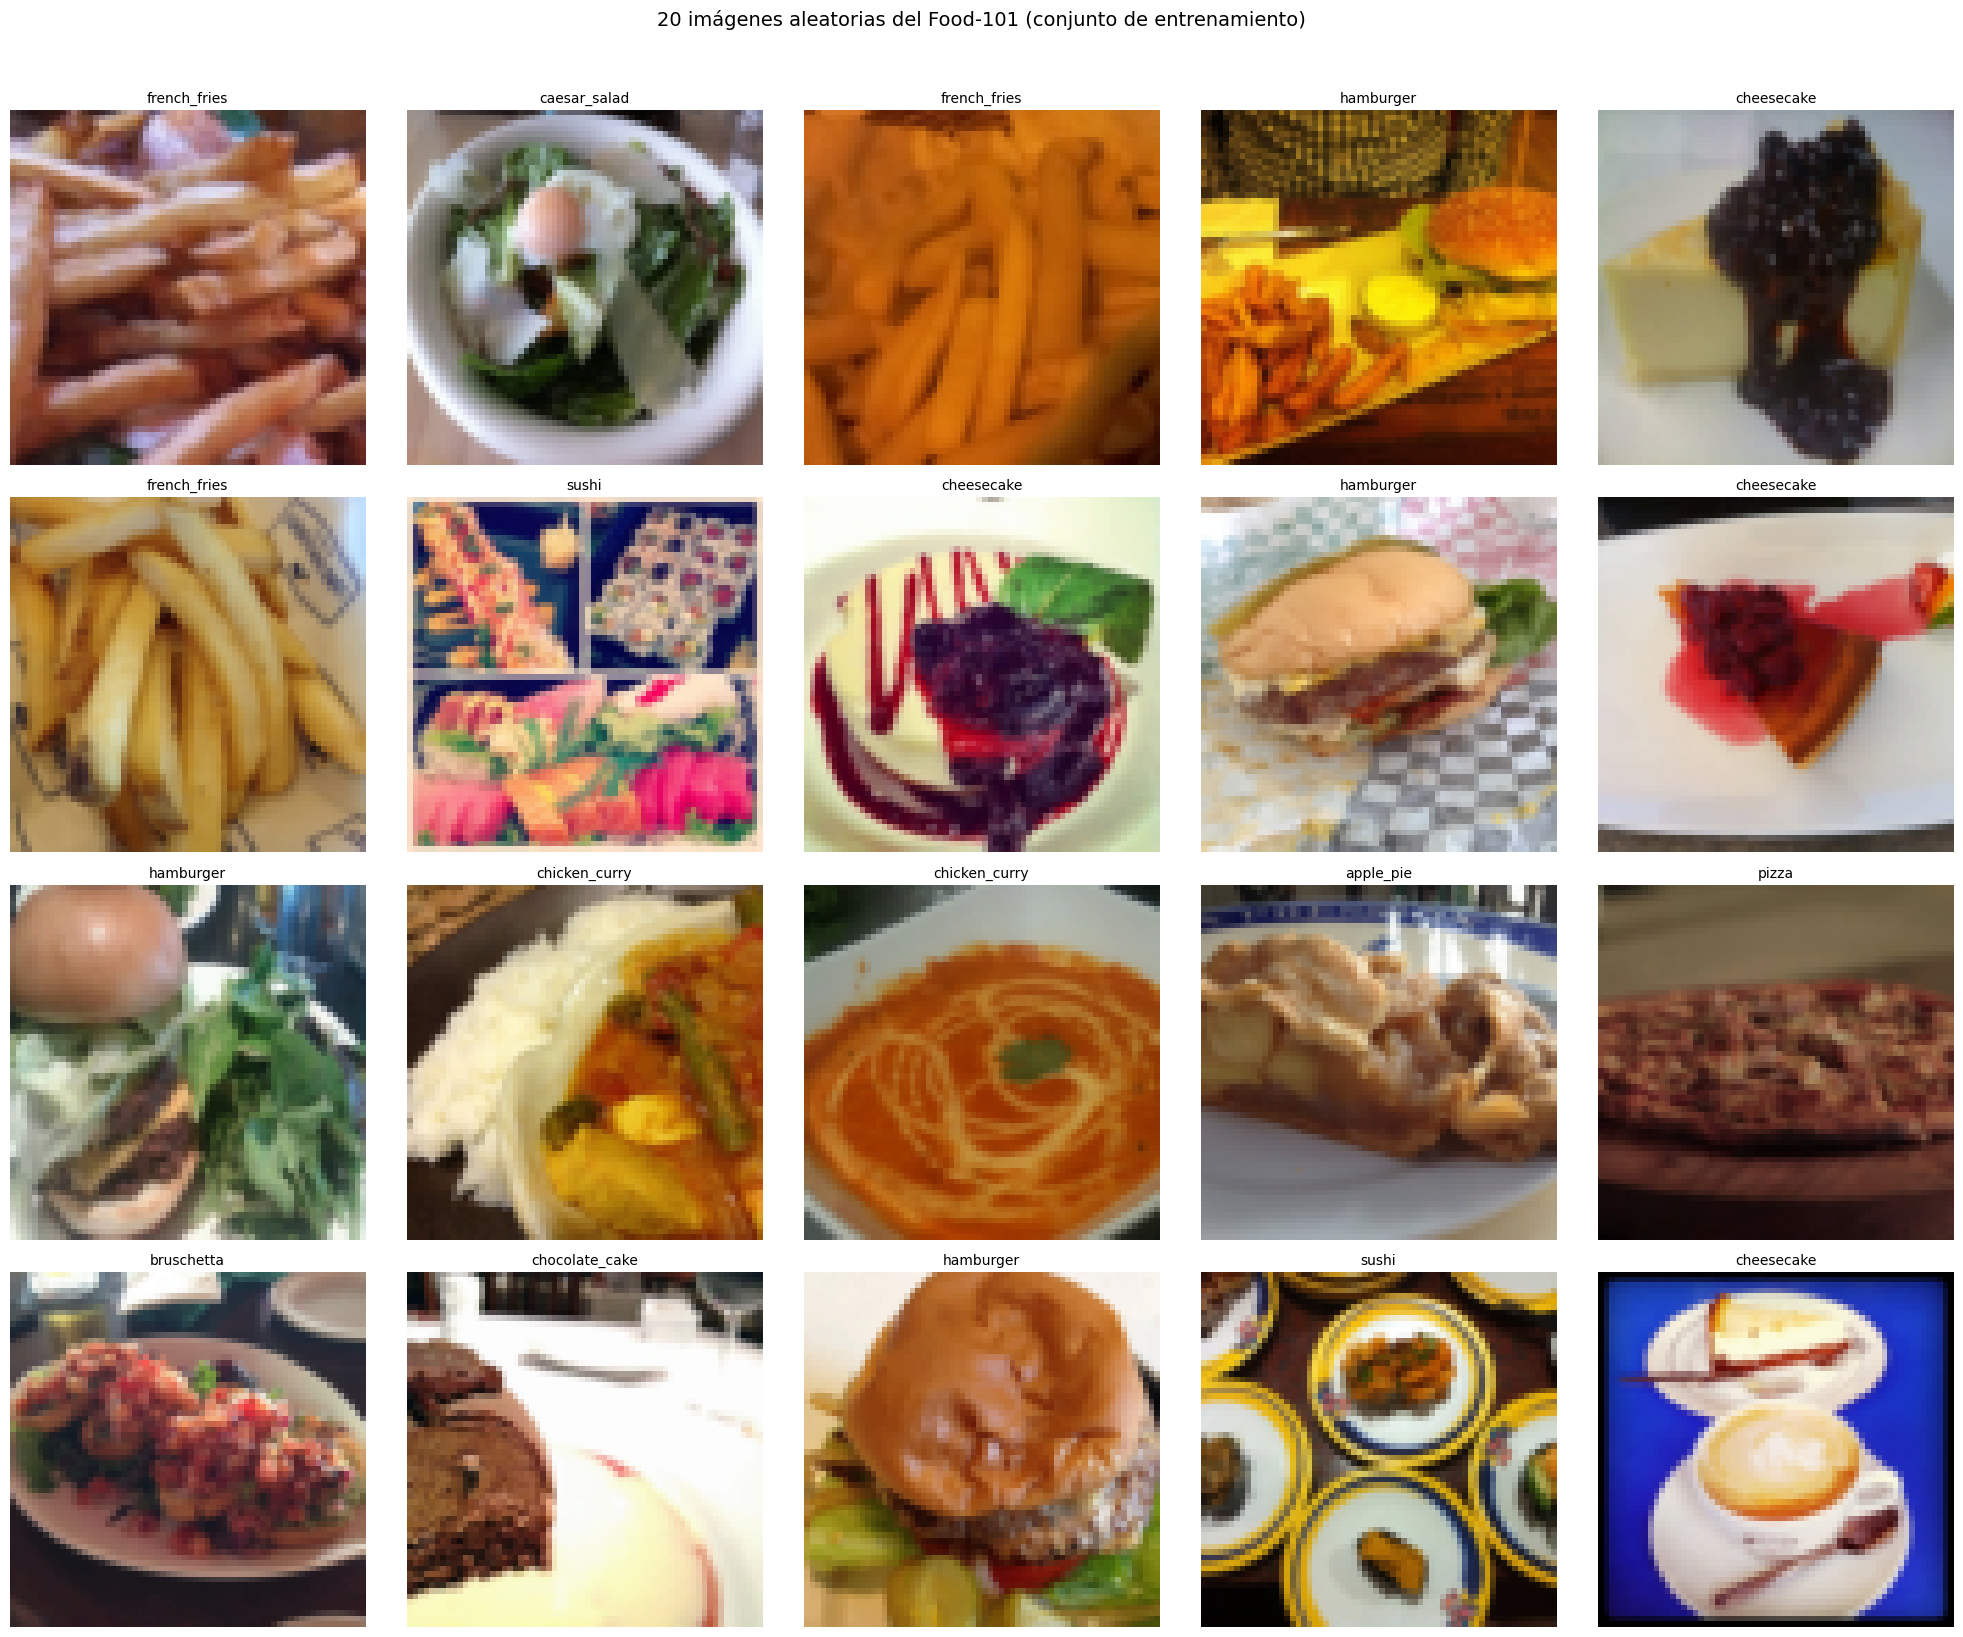

In [ ]:
import random

# Configuración
plt.figure(figsize=(20, 16))
n_images = 20
rows = 4
cols = 5

# Seleccionar índices aleatorios
random_indices = random.sample(range(len(train_dataset)), n_images)

# Mostrar imágenes
for i, idx in enumerate(random_indices):
    image, label = train_dataset[idx]

    # Desnormalizar la imagen
    image = image.numpy().transpose((1, 2, 0))  # Cambiar de CxHxW a HxWxC
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean  # Desnormalizar
    image = np.clip(image, 0, 1)  # Asegurar valores válidos

    # Mostrar imagen
    plt.subplot(rows, cols, i+1)
    plt.imshow(image)
    plt.title(f"{SELECTED_CLASSES[label]}", fontsize=10, pad=5)
    plt.axis('off')

plt.suptitle('20 imágenes aleatorias del Food-101 (conjunto de entrenamiento)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

**Dataloader**

In [ ]:
# Tamaño de lote para procesamiento
BATCH_SIZE = 64

# Cargador de entrenamiento: mezcla datos(Shuffle) y usa batches de 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Cargador de prueba: batches de 64 sin mezclar (para evaluación consistente)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

**Arquitectura MLP**

In [ ]:
# Definición de la red neuronal MLP
class FoodMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(FoodMLP, self).__init__()  # Hereda de nn.Module

        # Lista para almacenar todas las capas
        layers = []
        prev_size = input_size  # Tamaño inicial = dimensión de entrada

        # Construcción dinámica de capas ocultas
        for i, h_size in enumerate(hidden_sizes):
            layers.append(nn.Linear(prev_size, h_size))  # Capa lineal
            layers.append(nn.SiLU())  # Función de activación (alternativa a ReLU)
            prev_size = h_size  # Actualiza tamaño para siguiente capa

        # Secuencia completa de capas ocultas
        self.network = nn.Sequential(*layers)

        # Capa final de clasificación
        self.fc = nn.Linear(prev_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Aplana imagen a vector 1D
        x = self.network(x)  # Pasa por capas ocultas
        return self.fc(x)  # Salida final (logits)

# Configuración de hiperparámetros
INPUT_SIZE = 3 * IMG_SIZE * IMG_SIZE  # 3 canales RGB * 64x64 píxeles
HIDDEN_SIZES = [1024, 512, 256]  # Arquitectura decreciente
NUM_CLASSES = len(SELECTED_CLASSES)  # Número de clases a predecir

# Instanciación del modelo y envío a GPU/CPU
model = FoodMLP(INPUT_SIZE, HIDDEN_SIZES, NUM_CLASSES).to(device)

# Información de depuración
print(f"Tamaño de entrada: {INPUT_SIZE}")  # 12288 características
print(f"Número de clases: {NUM_CLASSES}")  # 10 clases de comida
print(f"Arquitectura del modelo:\n{model}")  # Imprime estructura completa

Tamaño de entrada: 12288
Número de clases: 10
Arquitectura del modelo:
FoodMLP(
  (network): Sequential(
    (0): Linear(in_features=12288, out_features=1024, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): SiLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): SiLU()
  )
  (fc): Linear(in_features=256, out_features=10, bias=True)
)


**Visualización de la arquitectura del MLP con decaimiento de neuronas**

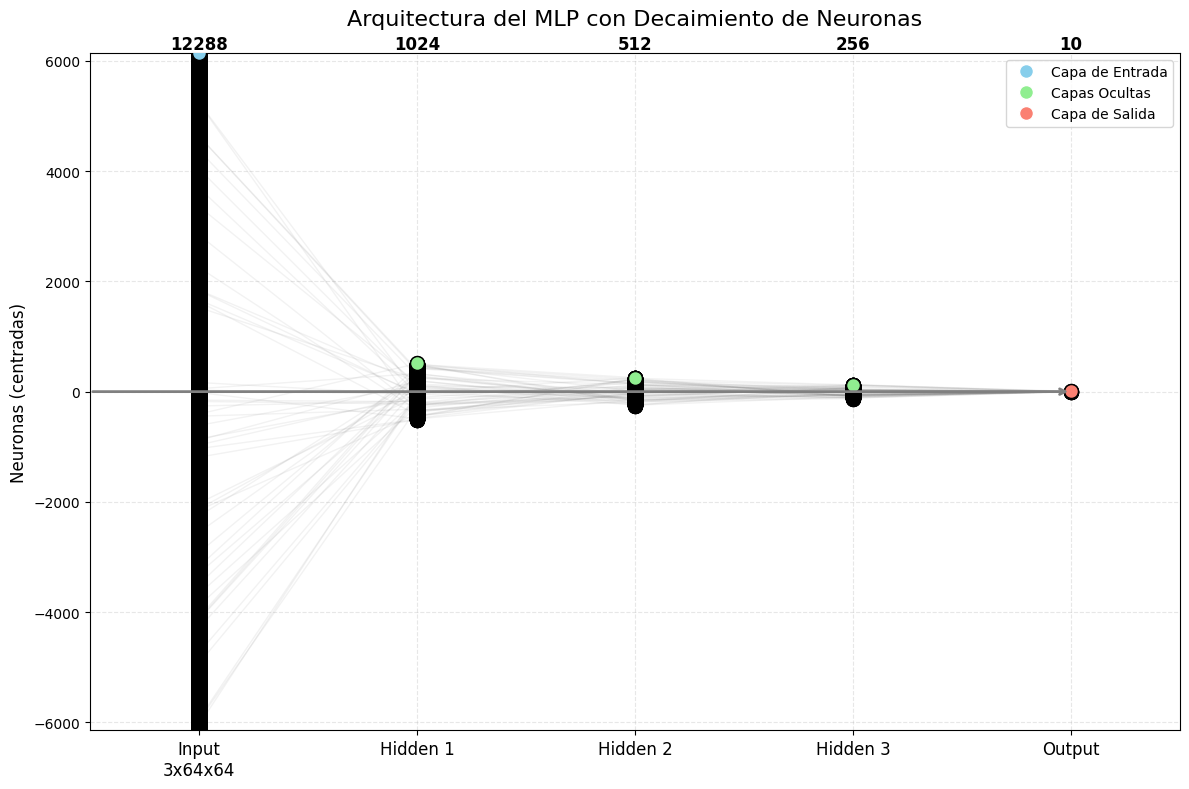

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_mlp_architecture(hidden_sizes, input_size=3*64*64, output_size=10):
    # Configuración
    layer_sizes = [input_size] + hidden_sizes + [output_size]
    max_neurons = max(layer_sizes)
    layer_count = len(layer_sizes)

    # Crear figura
    plt.figure(figsize=(12, 8))
    ax = plt.gca()

    # Dibujar capas
    for i, size in enumerate(layer_sizes):
        # Posición vertical centrada
        y_pos = np.linspace(-size/2, size/2, size) if size > 0 else [0]

        # Dibujar neuronas
        plt.scatter([i]*len(y_pos), y_pos, s=100,
                    color='skyblue' if i==0 else 'salmon' if i==len(layer_sizes)-1 else 'lightgreen',
                    edgecolor='k', zorder=3)

        # Etiquetas de tamaño de capa
        plt.text(i, max_neurons/2 + 0.5, f'{size}',
                 ha='center', va='bottom', fontsize=12, weight='bold')

    # Dibujar conexiones (simplificado)
    for i in range(layer_count-1):
        current_size = layer_sizes[i]
        next_size = layer_sizes[i+1]

        # Solo dibujar algunas conexiones para claridad
        for _ in range(50):
            src = np.random.randint(0, current_size)
            dst = np.random.randint(0, next_size)
            plt.plot([i, i+1],
                     [-current_size/2 + src*(current_size/max(1, current_size-1)),
                      -next_size/2 + dst*(next_size/max(1, next_size-1))],
                     'gray', alpha=0.1, lw=1)

    # Ajustes estéticos
    plt.xticks(range(layer_count),
               ['Input\n3x64x64'] + [f'Hidden {i+1}' for i in range(len(hidden_sizes))] + ['Output'],
               fontsize=12)
    plt.xlim(-0.5, layer_count-0.5)
    plt.ylim(-max_neurons/2 - 5, max_neurons/2 + 5)
    plt.title('Arquitectura del MLP con Decaimiento de Neuronas', fontsize=16, pad=20)
    plt.ylabel('Neuronas (centradas)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)

    # Leyenda
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Capa de Entrada',
        markerfacecolor='skyblue', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Capas Ocultas',
        markerfacecolor='lightgreen', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Capa de Salida',
        markerfacecolor='salmon', markersize=10)
    ]
    plt.legend(handles=legend_elements, loc='upper right', fontsize=10)

    # Añadir flecha de flujo
    plt.annotate('', xy=(layer_count-1, 0), xytext=(-0.5, 0),
                arrowprops=dict(arrowstyle='->', lw=2, color='gray'),
                annotation_clip=False)

    plt.tight_layout()
    plt.show()

# Usar tus hiperparámetros reales
plot_mlp_architecture(hidden_sizes=[1024, 512, 256],
                      input_size=3*64*64,
                      output_size=len(SELECTED_CLASSES))

**Gráfico comparativo de funciones de activación**

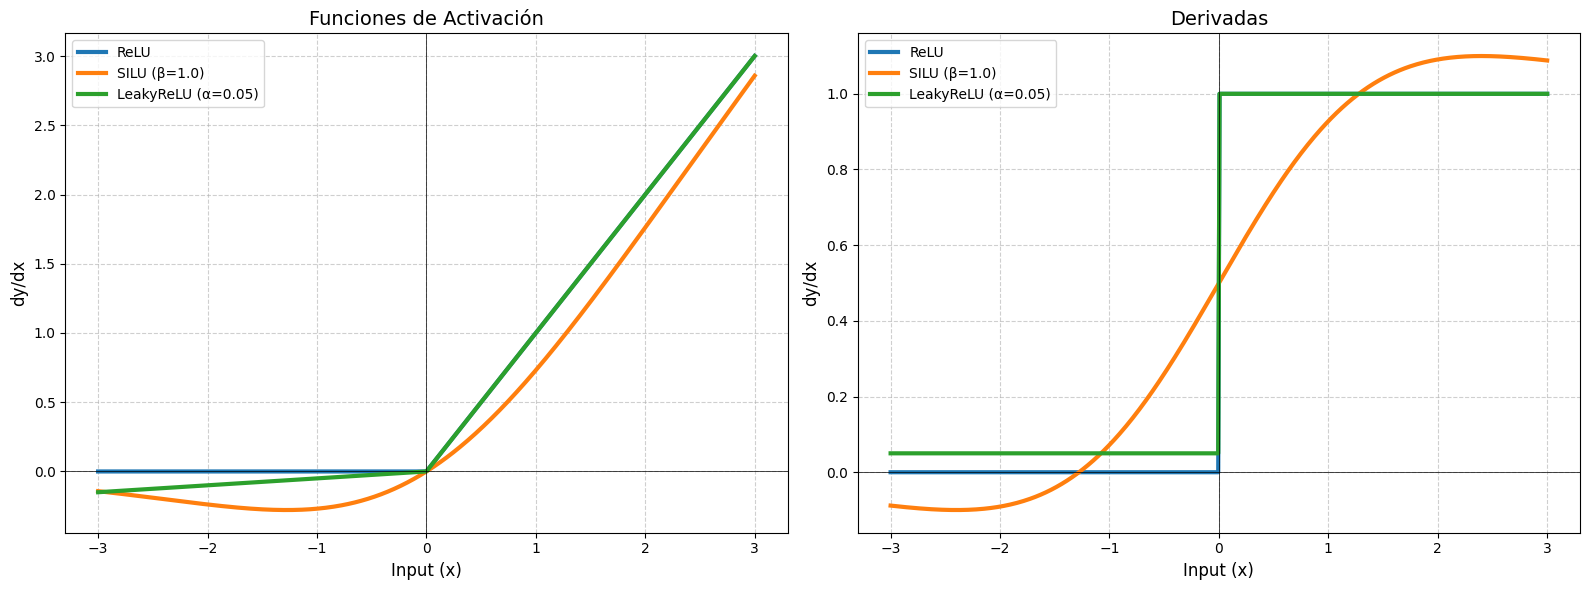

In [ ]:
def plot_custom_activations(leaky_alpha=0.01, silu_beta=1.0):
    x = torch.linspace(-3, 3, 500)
    activations = {
        f'ReLU': nn.ReLU(),
        f'SILU (β={silu_beta})': nn.SiLU(),
        f'LeakyReLU (α={leaky_alpha})': nn.LeakyReLU(leaky_alpha)
    }

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Funciones
    for name, func in activations.items():
        y = func(x)
        ax1.plot(x.numpy(), y.numpy(), label=name, lw=3)

    # Derivadas
    x.requires_grad_(True)
    for name, func in activations.items():
        y = func(x)
        y.sum().backward()
        grad = x.grad.clone()
        x.grad.zero_()
        ax2.plot(x.detach().numpy(), grad.detach().numpy(), label=name, lw=3)

    # Ajustes estéticos
    for ax, title in zip([ax1, ax2], ['Funciones de Activación', 'Derivadas']):
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('Input (x)', fontsize=12)
        ax.set_ylabel('Output' if title == 'Funciones' else 'dy/dx', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(fontsize=10)
        ax.axhline(0, color='black', linewidth=0.5)
        ax.axvline(0, color='black', linewidth=0.5)

    plt.tight_layout()
    plt.show()

# Ejemplo interactivo (puedes modificar los parámetros)
plot_custom_activations(leaky_alpha=0.05, silu_beta=1.0)

**Configurar Entrenamiento**

In [ ]:
# Función de pérdida para clasificación (incluye Softmax)
criterion = nn.CrossEntropyLoss()

# Optimizador Adam: ajusta tasas de aprendizaje por parámetro
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Reduce el learning rate x0.1 cada 4 épocas (para ajuste fino)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

**Entrenamiento**

In [ ]:
def train(model, dataloader, criterion, optimizer):
    model.train()  # Modo entrenamiento (activa Dropout/BatchNorm)
    running_loss = 0.0  # Acumulador de pérdida
    correct = 0  # Contador de aciertos
    total = 0  # Total de muestras

    for images, labels in dataloader:  # Lotes de datos
        # Mover datos al dispositivo (GPU/CPU)
        images, labels = images.to(device), labels.to(device)

        # Forward pass: predicción y cálculo de pérdida
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass: calcular gradientes y actualizar pesos
        optimizer.zero_grad()  # Resetear gradientes
        loss.backward()  # Calcula cómo cambiar los pesos para reducir el error
        #usa diferenciacion automatica (autograd) para propagar el error desde la salida hacia la entrada
        #nos dice en que direccion ajustar cada peso para reducir el error
        optimizer.step()  # Actualizar pesos usando los gradientes calculados

        # Calcular métricas
        running_loss += loss.item()  # Acumular pérdida
        _, predicted = torch.max(outputs.data, 1)  # Clase predicha
        total += labels.size(0)  # Total de muestras en lote
        correct += (predicted == labels).sum().item()  # Aciertos

    # Retornar pérdida y accuracy promedios
    return running_loss/len(dataloader), correct/total

def validate(model, dataloader, criterion):
    model.eval()  # Modo evaluación (desactiva Dropout/BatchNorm)
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Desactiva cálculo de gradientes (ahorro memoria)
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Solo forward pass (sin backpropagation)
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Calcular métricas
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Retornar métricas de validación
    return running_loss/len(dataloader), correct/total

**Bucle de entrenamiento**

In [ ]:
# Configuración del entrenamiento
EPOCHS = 15  # Número total de iteraciones sobre el dataset completo
train_losses = []  # Almacena pérdida de entrenamiento por época
val_losses = []    # Almacena pérdida de validación por época
accuracies = []    # Almacena precisión de validación por época
train_accuracies = []  # Almacena precisión de entrenamiento por época

best_val_acc = 0.0  # Mejor precisión de validación encontrada

# Bucle principal de entrenamiento
for epoch in range(EPOCHS):
    # Fase de entrenamiento (actualiza pesos)
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)

    # Fase de validación (sin actualizar pesos)
    val_loss, val_acc = validate(model, test_loader, criterion)

    # Ajustar learning rate según scheduler
    scheduler.step()  # Reduce LR si es necesario (según StepLR configurado)

    # Guardar métricas para gráficos
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accuracies.append(val_acc)
    train_accuracies.append(train_acc)

    # Mostrar progreso
    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")
    print("-"*50)

    # Guardar el mejor modelo
    if val_acc > best_val_acc:
        best_val_acc = val_acc  # Actualiza mejor precisión
        # Guarda los pesos del modelo (state_dict)
        torch.save(model.state_dict(), '/content/best_model.pth')
        print(f"Mejor modelo guardado con val_acc: {val_acc*100:.2f}%")

Epoch [1/15]
Train Loss: 1.6033 | Val Loss: 2.0081
Train Acc: 44.00% | Val Acc: 32.72%
--------------------------------------------------
Mejor modelo guardado con val_acc: 32.72%
Epoch [2/15]
Train Loss: 1.4530 | Val Loss: 2.1753
Train Acc: 49.27% | Val Acc: 30.36%
--------------------------------------------------
Epoch [3/15]
Train Loss: 1.0678 | Val Loss: 2.1531
Train Acc: 63.63% | Val Acc: 33.84%
--------------------------------------------------
Mejor modelo guardado con val_acc: 33.84%
Epoch [4/15]
Train Loss: 0.8517 | Val Loss: 2.2586
Train Acc: 71.36% | Val Acc: 34.72%
--------------------------------------------------
Mejor modelo guardado con val_acc: 34.72%
Epoch [5/15]
Train Loss: 0.7180 | Val Loss: 2.4074
Train Acc: 76.88% | Val Acc: 35.48%
--------------------------------------------------
Mejor modelo guardado con val_acc: 35.48%
Epoch [6/15]
Train Loss: 0.6085 | Val Loss: 2.5163
Train Acc: 81.04% | Val Acc: 34.36%
--------------------------------------------------
Epoc

**Descargar el mejor modelo**

In [ ]:
from google.colab import files

# Cargar el mejor modelo guardado (opcional para verificación)
model.load_state_dict(torch.load('/content/best_model.pth'))
model.eval()

# Descargar el archivo .pth
files.download('/content/best_model.pth')

print("¡Modelo descargado como 'best_model.pth'!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

¡Modelo descargado como 'best_model.pth'!


Gráficos de entrenamiento

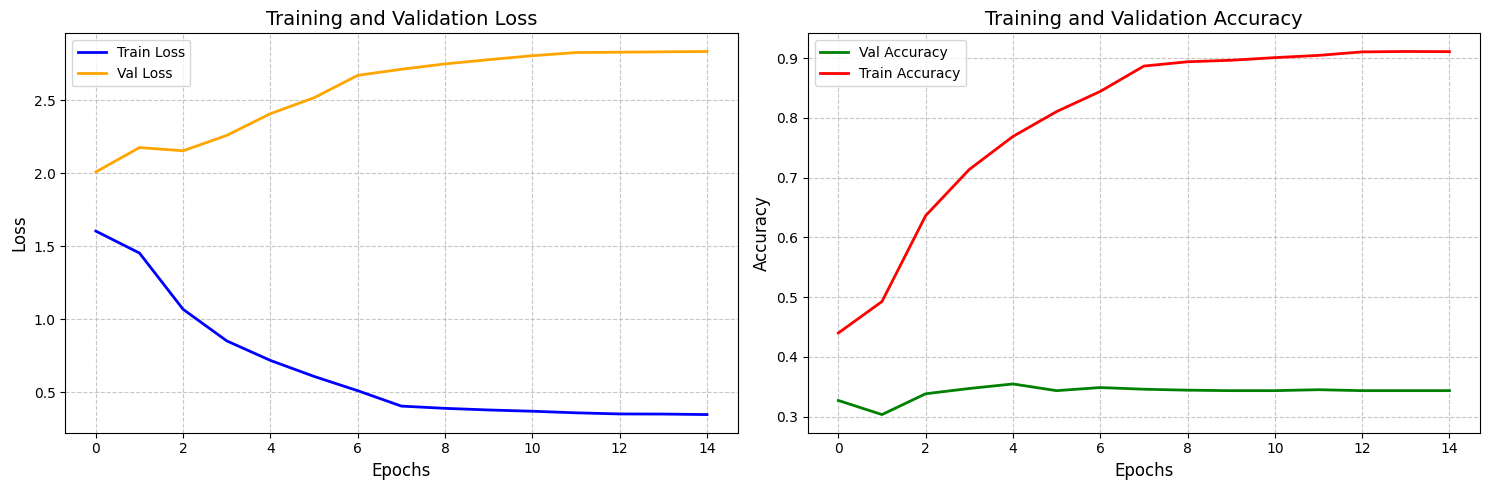

In [ ]:
plt.figure(figsize=(15, 5))  # Aumentamos el ancho para mejor visualización
# Gráfico 1: Evolución de la pérdida
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Val Loss', color='orange', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.title('Training and Validation Loss', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Gráfico 2: Evolución de la precisión
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Val Accuracy', color='green', linewidth=2)
# Si tienes train_accuracies guardadas:
plt.plot(train_accuracies, label='Train Accuracy', color='red', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.title('Training and Validation Accuracy', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()  # Evita superposiciones
plt.show()

**Visualización de 10 imágenes aleatorias con predicciones**

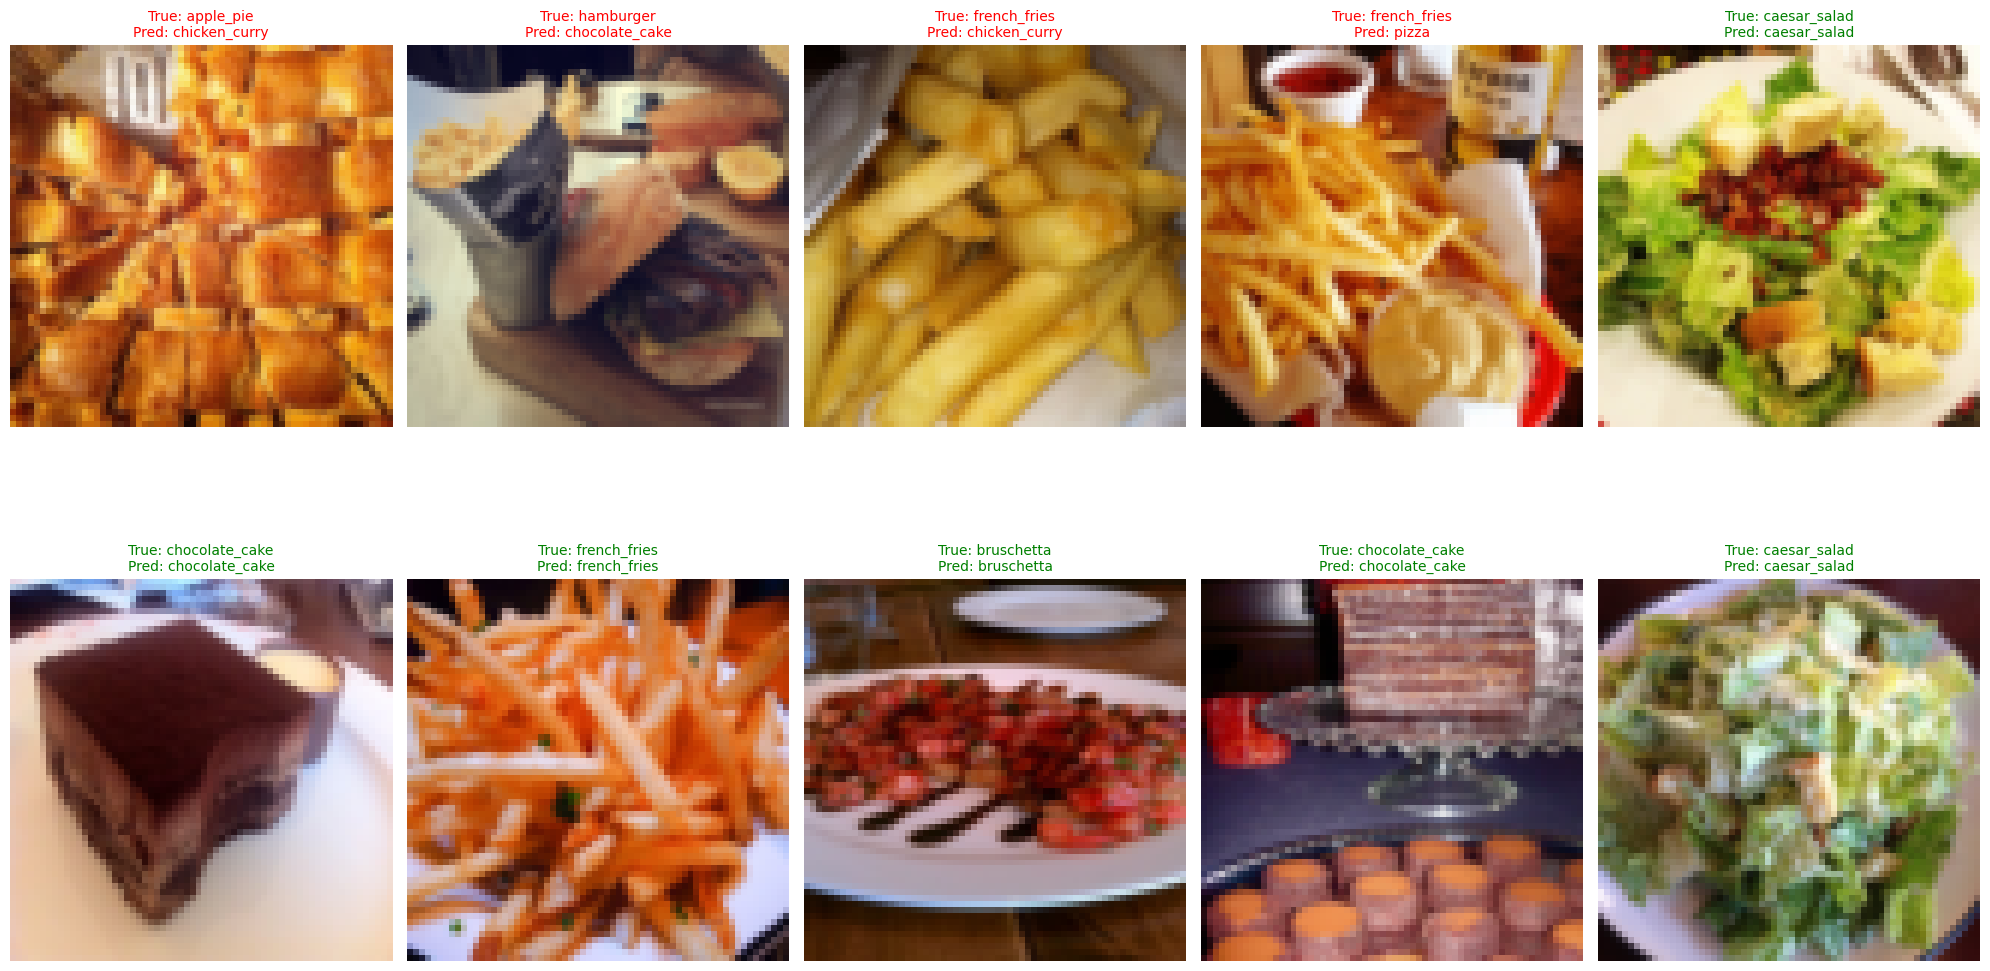


Accuracy en estas 10 imágenes: 60.00% (6/10)


In [ ]:
def imshow(img):
    # Desnormalización correcta para ImageNet
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img * std + mean  # Desnormalizar correctamente
    img = torch.clamp(img, 0, 1)  # Asegurar valores válidos
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Seleccionar 10 índices aleatorios
random_indices = torch.randperm(len(test_dataset))[:10]

# Obtener las imágenes y etiquetas
random_images = []
random_labels = []
for idx in random_indices:
    img, label = test_dataset[idx]
    random_images.append(img)
    random_labels.append(label)
random_images = torch.stack(random_images)
random_labels = torch.tensor(random_labels)

# Obtener predicciones
model.eval()
with torch.no_grad():
    random_images = random_images.to(device)
    outputs = model(random_images)
    _, predicted = torch.max(outputs, 1)
    predicted = predicted.cpu()

# Mover a CPU para visualización
random_images = random_images.cpu()

# Mostrar las 10 imágenes con predicciones
plt.figure(figsize=(20, 12))
for i in range(10):
    plt.subplot(2, 5, i+1)  # 2 filas x 5 columnas
    imshow(random_images[i])

    true_label = SELECTED_CLASSES[random_labels[i]]
    pred_label = SELECTED_CLASSES[predicted[i]]

    color = 'green' if true_label == pred_label else 'red'

    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Mostrar estadísticas de accuracy
matches = (predicted == random_labels).sum().item()
print(f"\nAccuracy en estas 10 imágenes: {matches/10*100:.2f}% ({matches}/10)")

**Matriz de confusión**

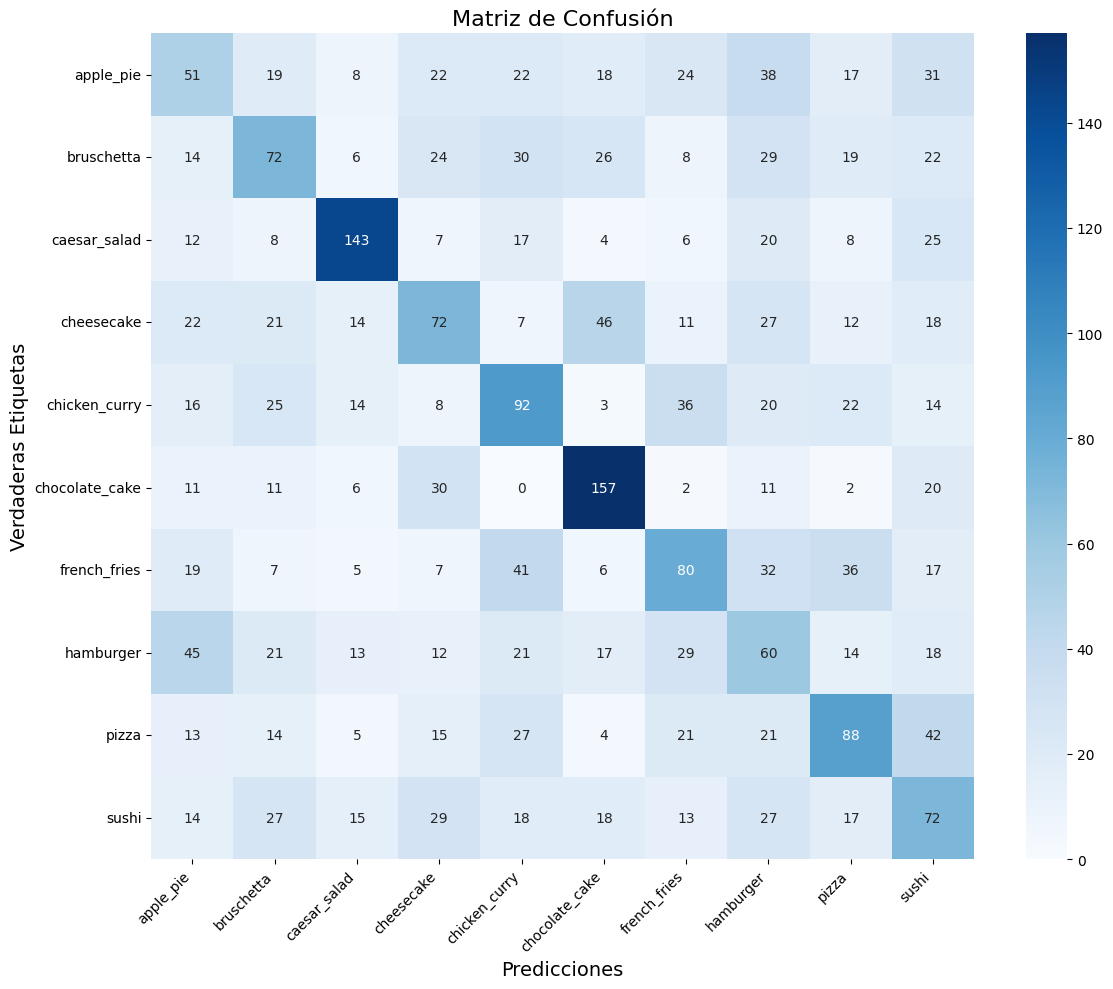

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

# 1. Cargar el mejor modelo
model.load_state_dict(torch.load('/content/best_model.pth'))
model.eval()

# 2. Obtener todas las predicciones del conjunto de prueba
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Convertir a arrays numpy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# %% [code] 1. Matriz de Confusión
plt.figure(figsize=(12, 10))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=SELECTED_CLASSES,
            yticklabels=SELECTED_CLASSES)
plt.title('Matriz de Confusión', fontsize=16)
plt.xlabel('Predicciones', fontsize=14)
plt.ylabel('Verdaderas Etiquetas', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



**Gráfico de Accuracy por Clase**

<ipython-input-16-d8b936e524f5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=SELECTED_CLASSES, y=class_acc, palette='viridis')


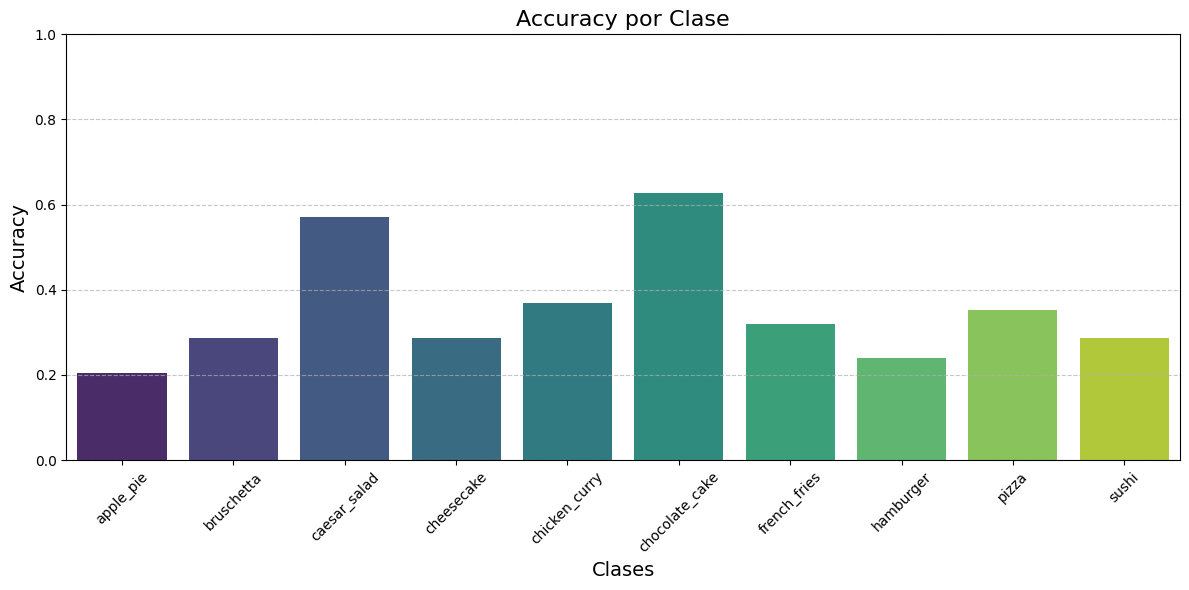

In [ ]:
class_acc = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(12, 6))
sns.barplot(x=SELECTED_CLASSES, y=class_acc, palette='viridis')
plt.title('Accuracy por Clase', fontsize=16)
plt.xlabel('Clases', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

